In [1]:
import yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score as AUC
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score

In [2]:
def missing_values(data):
    """ Fill in missing values
    """
    for i in data.columns:
        if data[i].dtype == 'object':
            data[i] = data[i].fillna(data[i].mode().iloc[0])
        if (data[i].dtype == 'int' or data[i].dtype == 'float'):
            data[i] = data[i].fillna(np.mean(data[i]))
            
    return data
    

In [3]:
def label_encoding(data):
    """Encode catgegorical variables
    """
    number = LabelEncoder()
    for i in data.columns:
        if (data[i].dtype == 'object'):
            data[i] = number.fit_transform(data[i].astype('str'))
            data[i] = data[i].astype('object')
            
    return data

In [4]:
def preprocess(train, test, target):
    """Preprocessing 
    """
    ## missing values
    train = missing_values(train)
    test = missing_values(test)
    
    ### label encoding
    train = label_encoding(train) 
    test = label_encoding(test)
    
    return train, test


In [5]:
def test_weights(test, train, target):
    """Calculate test weights
    """
    # Adding a column to identify whether a row comes from train or not
    test.loc[:,('is_train')] = 0
    train.loc[:,('is_train')] = 1 
    
    # Combining test and train data
    df_combine = pd.concat([train, test], axis=0, ignore_index=True)
    
    # Dropping ‘target’ column as it is not present in the test
    df_combine = df_combine.drop(target, axis =1)
    
    # Labels
    y = df_combine['is_train'].values 
    
    # Covariates or our independent variables
    x = df_combine.drop('is_train', axis=1).values 
    tst, trn = test.values, train.values
    
    # Predict the labels for each row in the combined dataset. 
    m = RandomForestClassifier(n_jobs=-1, max_depth=5, min_samples_leaf = 5)
    predictions = np.zeros((y.shape[0],2)) #creating an empty prediction array
    
    # Stratified fold to ensure that percentage for each class is preserved 
    # and we cover the whole data once. 
    # For each row the classifier will calculate the probability of it belonging to train.
    skf = StratifiedKFold(n_splits=20, shuffle=True, random_state=100)
    for fold, (train_idx, test_idx) in enumerate(skf.split(x, y)):
        X_train, X_test = x[train_idx], x[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
 
        m.fit(X_train, y_train)
        predictions[test_idx] = m.predict_proba(X_test) #calculating the probability
        
    # High AUC (greater than 0.8) implies strong covariate shift between train and test.
    auc =  AUC(y, predictions[:, 1])
    
    predictions_test = predictions[len(trn):]
    #Test relevance weights equal to the probability of test sample to be in train set
    test_relevance_weights = predictions_test[:,1]
    
    return auc, test_relevance_weights, predictions

In [6]:
def sub_to_csv(id_name, target, test, pred, file_name):
    """Create Kaggle submission
    """
    sub = pd.DataFrame()
    sub[id_name] = test[id_name]
    sub[target] = pred
    sub.to_csv(file_name, index=False)

In [7]:
def explore(config_file):
    """ Check if covariate shift exists in datasets.
    
        Input:
            config_file - path to yaml configuration file with the following structure:
                TRAIN_CSV - path to train set
                TEST_CSV - path to test set
                SEP - csv separator
                TARGET - target variable in train
                PREP - is preprocessing needed boolean 
                
    """
    with open(config_file, "r") as stream:
        try:
            cfg = yaml.safe_load(stream)
            print(cfg)
        except yaml.YAMLError as exc:
            print(exc)
    
    # getting parameters
    train_csv = cfg['TRAIN_CSV']
    test_csv = cfg['TEST_CSV']
    sep = cfg['SEP']
    target = cfg['TARGET']
    id_name = cfg['ID']
    is_prep = cfg['PREP']
    out = cfg['OUT'] 
    train_sample_size = cfg['TRAIN_SAMPLE_SIZE'] 
    test_sample_size = cfg['TEST_SAMPLE_SIZE']
    training_df_name = out+'training.csv'
    testing_df_name = out+'testing.csv'
    WITH_DRIFTING_FILE = out+"with_drifting.csv"
    WITHOUT_DRIFTING_FILE = out+"without_drifting.csv"
    
    drift_threashold = 0.8

    print("train_csv: {}\n test_csv: {}\n sep: {}\n target: {}\n is_prep: {}".
          format(train_csv, test_csv, sep, target, is_prep))
    print("out: {}\n train_sample_size: {}\n test_sample_size: {}".
          format(out, train_sample_size, test_sample_size))
    print("------------------------")
    
    ## reading files
    train_all = pd.read_csv(train_csv, sep = sep, index_col=False)
    test_all = pd.read_csv(test_csv, sep = sep, index_col=False)
    
    print("*** All Train ***")
    #print(train_all.describe())
    print(train_all.info())

    print("------------------------")
    print("*** All Test ***")
    #print(test_all.describe())
    print(test_all.info())
    print("------------------------")
    
    if target in set(train_all.columns):
        print("Target: ", target)
    else:
        print("Target {} not found!".format(target))

    print("*** Preprocessing ... ")
    train, test = preprocess(train_all, test_all, target)
    
    print("*** Taking sample from training and test data ...")
    if train_sample_size != 0:
        training = train.sample(train_sample_size, random_state=12)
    else:
        training = train
    print("Training sample: ", len(training))
    
    if test_sample_size != 0:
        testing = test.sample(test_sample_size, random_state=11)
    else:
        testing = test
    print("Testing sample: ", len(testing))
        
    training.to_csv(training_df_name, index=False)
    testing.to_csv(testing_df_name, index=False)
    
    print("*** Check if covariate shift exists and get test relvance weights ...") 
    auc, test_relevance_weights, predictions = test_weights(testing, training, target)   
    print("*** AUC: {} ***".format(auc))
    print(
    """
    AUC > 0.9 indicates that train and test sets are well separated.
    Train and test sets and have different distributions,
    """
    )
    print("*** Test relevance weights ***")
    _=sns.histplot(test_relevance_weights, kde=False)
    
    print("""
    Create a random sample of training and test data and add a new feature is_test, 
    which has value True (1) for data from test set and False (0) for data from training set. 
    Combine these random samples into a single dataset...
    """)
    train['is_test'] = 0
    test['is_test'] = 1
    training = train.drop(target,axis=1) #droping target variable

    print("*** Take random sample from training and test data and combine them ...")
    training = training.sample(7662, random_state=12)
    testing = test.sample(7000, random_state=11)
    combi = training.append(testing)
    y = combi['is_test']
    combi.drop('is_test',axis=1,inplace=True)
    
    print("""
    Create a model and predict one feature at a time if feature is_test. 
    
    Evaluate a AUC-ROC score by cross-validation.
    
    Find drifting features:
    If the value of AUC-ROC for a particular feature is greater then Drift Threashold -
    classify that feature as drifting...
    """)
    
    print("*** Drifting Threashold: ", drift_threashold)
    print("*** Drifting Features: ...")
    model = RandomForestClassifier(n_estimators = 50, max_depth = 5,min_samples_leaf = 5)
                              #random_state=42)
    drop_list = []
    for i in combi.columns:
        score = cross_val_score(model,pd.DataFrame(combi[i]),y,cv=2,scoring='roc_auc')
        if (np.mean(score) > drift_threashold):
            drop_list.append(i)
            print(i,np.mean(score))
    
    print("""
    *** Use a basic model with all the features to check which features are important...
    """)
    training = train.drop('is_test',axis=1)
    testing = test.drop('is_test',axis=1)

    rf = RandomForestRegressor(n_estimators=200, max_depth=6,max_features=10)
    rf.fit(training.drop(target,axis=1),training[target])
    pred = rf.predict(testing)
    
    print("*** Create Kaggle submission ...")
    sub_to_csv(id_name, target, test, pred, WITH_DRIFTING_FILE)
    
    features = training.columns.values
    imp = rf.feature_importances_
    indices = np.argsort(imp)[::-1][:20]
    first_20 = features[indices]
    print("20 most important features for this model")
    print(first_20)

    plt.figure(figsize=(8,5))
    plt.bar(range(len(indices)), imp[indices], color = 'b', align='center')
    plt.xticks(range(len(indices)), first_20, rotation='vertical')
    plt.xlim([-1,len(indices)])
    plt.show()
    
    print("*** Keep features from most important list ***")
    to_keep = set(drop_list).intersection(first_20)
    print(to_keep)
    
    print("""
    We keep these features in our model and drop the rest of the drifting features.
    NOTE: Before dropping any feature, it make sense to check any possibility to create a new feature from it.
    Features to drop:
    """)
    drop_set = set(drop_list) - set(first_20)
    print(drop_set)
    
    print("""
    Train model dropping driffting features which are not important. Predict...
    """)
    drift_train = train.drop(drop_set, axis=1)
    drift_test = test.drop(drop_set, axis=1)
    rf = RandomForestRegressor(n_estimators=200, max_depth=6,max_features=10)
    rf.fit(drift_train.drop(target, axis=1),drift_train[target])
    pred = rf.predict(drift_test)
    
    print("*** Create Kaggle submission ***")
    sub_to_csv(id_name, target, test, pred, WITHOUT_DRIFTING_FILE)    

### <b> Sberbank Russian Housing Market </b>
https://www.kaggle.com/c/sberbank-russian-housing-market

{'TRAIN_CSV': '../data/sber/train.csv', 'TEST_CSV': '../data/sber/test.csv', 'SEP': ',', 'TRAIN_SAMPLE_SIZE': 7662, 'TEST_SAMPLE_SIZE': 7000, 'OUT': '../data/sber/out/', 'TARGET': 'price_doc', 'ID': 'id', 'PREP': True}
train_csv: ../data/sber/train.csv
 test_csv: ../data/sber/test.csv
 sep: ,
 target: price_doc
 is_prep: True
out: ../data/sber/out/
 train_sample_size: 7662
 test_sample_size: 7000
------------------------
*** All Train ***
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30471 entries, 0 to 30470
Columns: 292 entries, id to price_doc
dtypes: float64(119), int64(157), object(16)
memory usage: 67.9+ MB
None
------------------------
*** All Test ***
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7662 entries, 0 to 7661
Columns: 291 entries, id to market_count_5000
dtypes: float64(116), int64(159), object(16)
memory usage: 17.0+ MB
None
------------------------
Target:  price_doc
*** Preprocessing ... 
*** Taking sample from training and test data ...
Training sample:  

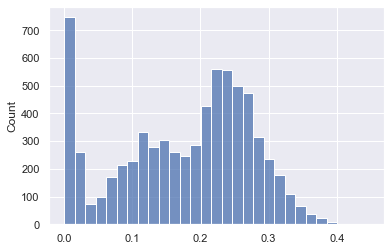

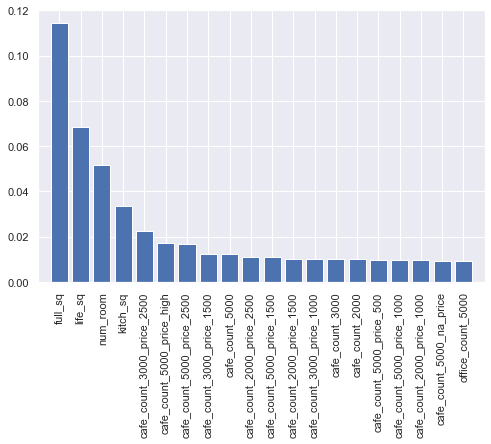

*** Keep features from most important list ***
{'kitch_sq', 'life_sq'}

    We keep these features in our model and drop the rest of the drifting features.
    NOTE: Before dropping any feature, it make sense to check any possibility to create a new feature from it.
    Features to drop:
    
{'timestamp', 'hospital_beds_raion', 'id', 'cafe_avg_price_500', 'build_year', 'cafe_sum_500_min_price_avg', 'cafe_sum_500_max_price_avg'}

    Train model dropping driffting features which are not important. Predict...
    
*** Create Kaggle submission ***


In [8]:
explore('sber.cfg')

### <b>Home Credit Default Risk<b>
https://www.kaggle.com/c/home-credit-default-risk

{'TRAIN_CSV': '../data/home-credit/application_train.csv', 'TEST_CSV': '../data/home-credit/application_test.csv', 'SEP': ',', 'TRAIN_SAMPLE_SIZE': 5000, 'TEST_SAMPLE_SIZE': 5000, 'OUT': '../data/home-credit/out/', 'TARGET': 'TARGET', 'ID': 'SK_ID_CURR', 'PREP': True}
train_csv: ../data/home-credit/application_train.csv
 test_csv: ../data/home-credit/application_test.csv
 sep: ,
 target: TARGET
 is_prep: True
out: ../data/home-credit/out/
 train_sample_size: 5000
 test_sample_size: 5000
------------------------
*** All Train ***
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB
None
------------------------
*** All Test ***
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48744 entries, 0 to 48743
Columns: 121 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(40), object(16)
memory usage: 45.0+ MB
None


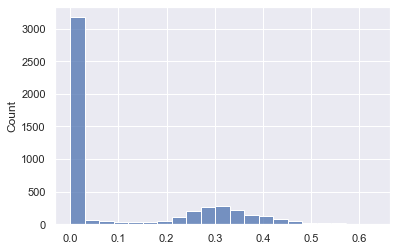

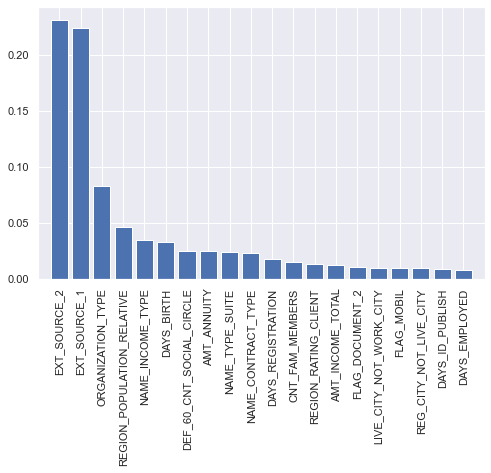

*** Keep features from most important list ***
{'NAME_INCOME_TYPE', 'EXT_SOURCE_1'}

    We keep these features in our model and drop the rest of the drifting features.
    NOTE: Before dropping any feature, it make sense to check any possibility to create a new feature from it.
    Features to drop:
    
{'ENTRANCES_MEDI', 'ENTRANCES_AVG', 'TOTALAREA_MODE', 'NONLIVINGAREA_AVG', 'APARTMENTS_AVG', 'APARTMENTS_MODE', 'LIVINGAREA_MEDI', 'LIVINGAPARTMENTS_AVG', 'LIVINGAPARTMENTS_MODE', 'NONLIVINGAPARTMENTS_MEDI', 'FLOORSMAX_MODE', 'LIVINGAREA_AVG', 'OWN_CAR_AGE', 'FLOORSMIN_AVG', 'FLOORSMIN_MEDI', 'LANDAREA_AVG', 'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI', 'NONLIVINGAREA_MEDI', 'NONLIVINGAPARTMENTS_MODE', 'ENTRANCES_MODE', 'ELEVATORS_AVG', 'NONLIVINGAPARTMENTS_AVG', 'COMMONAREA_MODE', 'BASEMENTAREA_AVG', 'COMMONAREA_AVG', 'ELEVATORS_MODE', 'LIVINGAREA_MODE', 'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BUILD_MODE', 'YEARS_BUILD_AVG', 'YEARS_BEGINEXPLUATATION_MODE', 'LIVINGAPARTMENTS_MEDI', 'YEARS_B

In [9]:
explore('home-credit.cfg')